<h1 style="text-align: center;"><strong>Meeting Report</strong></h1>


### IMPORT

In [170]:
import pandas as pd
import numpy as np
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from _data_manager import DataManager
from _trade import Trade
from _long_short_trade import TradeLongShort
from _backtesting import Backtest
from _strategy_linear_regression import StrategyLinearRegression, StrategyLinearRegressionMultiAgent
from _strategy_cross_yield import StrategyCrossYield
from _trade_filter import TradeFilter
from _strategy_comparator import StratgiesComparetor
from _strategy_linear_optimisation_time import AssetSelectioByModel




In [140]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Option d'affichage


In [71]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore')



# DATA ANALYSIS

To work efficiently with data, I created the `DataManager` class. This class streamlines the necessary transformations for analyzing bond yields. It loads the data, organizes it by date, country, and maturity, and calculates key statistics such as ranks, yield spreads, averages, and rolling standard deviations, thereby enabling a thorough and comparative analysis of bond performance.

In [72]:
file_path = 'EGB_historical_yield.csv'
data_manager = DataManager(file_path)


In [73]:
data_manager.data.shape

(2110, 21)

In [74]:
data_manager.data.head()

,Germany_5y,Germany_10y,Germany_30y,Belgium_5y,Belgium_10y,Belgium_30y,Austria_5y,Austria_10y,Austria_30y,Netherlands_5y,Netherlands_10y,Netherlands_30y,France_5y,France_10y,France_30y,Spain_5y,Spain_10y,Spain_30y,Italy_5y,Italy_10y,Italy_30y
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15,-16.4,53.9,131.2,-2.1,83.8,189.7,-8,77.7,160.4,-10.4,66.1,143.6,-10.4,66.1,143.6,65.4,175.0,291.2,56.1,156.4,264.9
2016-01-18,-16.6,53.6,131.2,-3.3,83.5,190.0,-8,77.4,160.7,-10.6,66.0,143.9,-10.6,66.0,143.9,64.0,174.0,291.5,56.6,156.4,266.9
2016-01-19,-16.7,54.8,132.2,-4.1,84.0,189.9,-8,78.3,161.8,-11.3,66.1,145.1,-11.3,66.1,145.1,60.5,170.1,288.2,55.3,155.7,265.2
2016-01-20,-19.8,48.1,122.5,-6.0,96.3,184.2,-11,73.2,153.1,-13.8,60.9,135.9,-13.8,60.9,135.9,65.7,178.2,296.7,62.2,164.9,275.9
2016-01-21,-24.0,44.9,121.4,-9.8,91.5,180.5,-16,69.6,153.0,-18.2,57.0,134.8,-18.2,57.0,134.8,60.2,171.9,291.5,54.4,156.1,269.5


In [75]:
data_manager.data.dtypes

Germany_5y         float64
Germany_10y        float64
Germany_30y        float64
Belgium_5y         float64
Belgium_10y        float64
Belgium_30y        float64
Austria_5y           int64
Austria_10y        float64
Austria_30y        float64
Netherlands_5y     float64
Netherlands_10y    float64
Netherlands_30y    float64
France_5y          float64
France_10y         float64
France_30y         float64
Spain_5y           float64
Spain_10y          float64
Spain_30y          float64
Italy_5y           float64
Italy_10y          float64
Italy_30y          float64
dtype: object

For the Austria 5-year rates, we only have `int64` data types, which likely indicates a lack of precision in this measurement compared to others. Given 2110 rows, the probability of having only integer numbers is virtually zero.

In [76]:
data_manager.data.isnull().sum().sort_values().head(3)

Germany_5y    0
Italy_5y      0
Spain_30y     0
dtype: int64

There are no missing data, which is good news.

In [77]:
data_manager.data.describe()

,Germany_5y,Germany_10y,Germany_30y,Belgium_5y,Belgium_10y,Belgium_30y,Austria_5y,Austria_10y,Austria_30y,Netherlands_5y,Netherlands_10y,Netherlands_30y,France_5y,France_10y,France_30y,Spain_5y,Spain_10y,Spain_30y,Italy_5y,Italy_10y,Italy_30y
count,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000
mean,11.990521,47.930995,94.990332,31.534313,88.705403,165.658104,29.082938,79.211185,135.861327,18.575592,66.287488,104.963886,18.575592,66.287488,104.963886,69.074645,145.899763,236.917393,135.596066,219.323081,301.104076
std,110.244206,97.853356,84.547229,116.515992,109.453098,96.159139,119.676026,112.184716,93.752196,116.077422,104.988257,90.751273,116.077422,104.988257,90.751273,116.066133,106.837146,97.354064,127.540894,120.103048,96.317931
min,-99.100000,-85.800000,-49.300000,-72.400000,-43.600000,26.400000,-76.000000,-48.500000,-6.600000,-86.800000,-65.200000,-38.100000,-86.800000,-65.200000,-38.100000,-45.700000,-1.900000,79.600000,-12.600000,45.500000,138.200000
25%,-58.500000,-26.275000,24.000000,-43.275000,7.200000,84.825000,-44.000000,-2.575000,56.200000,-52.800000,-12.275000,28.600000,-52.800000,-12.275000,28.600000,-13.400000,46.650000,136.625000,36.425000,121.650000,220.900000
50%,-35.400000,25.100000,90.850000,-19.650000,64.700000,160.600000,-25.000000,49.500000,132.500000,-32.200000,41.450000,99.350000,-32.200000,41.450000,99.350000,29.050000,140.150000,251.050000,78.050000,196.100000,302.650000
75%,4.050000,61.125000,127.550000,22.300000,95.750000,185.075000,14.000000,80.775000,157.800000,-2.550000,73.675000,131.000000,-2.550000,73.675000,131.000000,61.675000,169.075000,288.275000,212.850000,298.525000,361.925000
max,289.100000,296.600000,320.600000,324.400000,362.800000,418.800000,332.000000,358.400000,379.100000,313.000000,331.100000,344.600000,313.000000,331.100000,344.600000,368.300000,406.600000,469.100000,435.100000,497.900000,544.200000


In [78]:
data_manager.data.std(axis=0).sort_values()

Germany_30y         84.547229
France_30y          90.751273
Netherlands_30y     90.751273
Austria_30y         93.752196
Belgium_30y         96.159139
Italy_30y           96.317931
Spain_30y           97.354064
Germany_10y         97.853356
France_10y         104.988257
Netherlands_10y    104.988257
Spain_10y          106.837146
Belgium_10y        109.453098
Germany_5y         110.244206
Austria_10y        112.184716
Spain_5y           116.066133
France_5y          116.077422
Netherlands_5y     116.077422
Belgium_5y         116.515992
Austria_5y         119.676026
Italy_10y          120.103048
Italy_5y           127.540894
dtype: float64

Long-term bonds are generally less volatile than short-term ones, but there are some exceptions, such as the 5-year German bond (which is in the 10-year group), or Italy 10-year, which is the second most volatile bond. This indicates higher uncertainty for Italy and lower uncertainty for Germany, which is more stable. Interestingly, the order by maturity is roughly but not always consistent (such as with Spain for the 5-year rate, which is second vs. last for the 30-year rate).

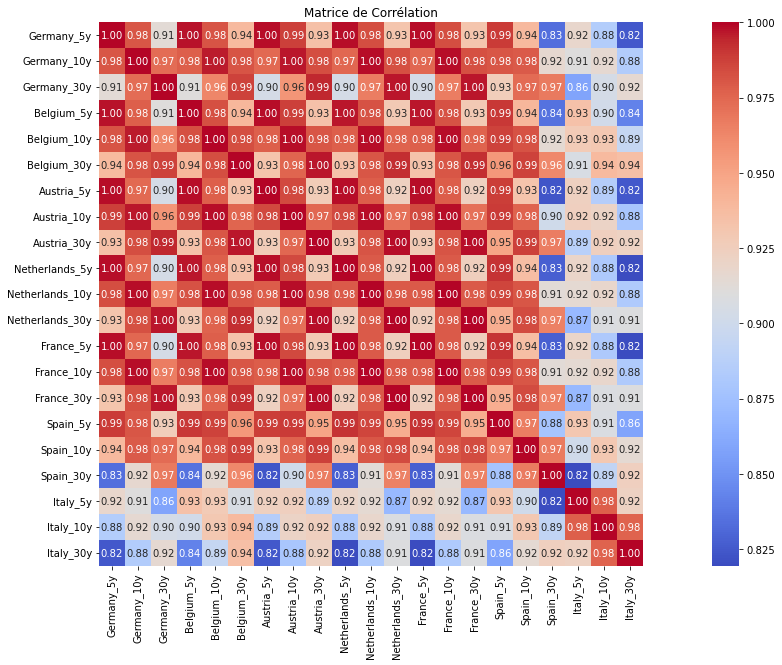

In [79]:
corr = data_manager.data.corr()

plt.figure(figsize=(25, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.title('Matrice de Corrélation')
plt.show()

The set is highly correlated, with Italy appearing to be significantly less correlated than other nations with each other. It is observed that in many instances, countries with equal maturity have almost perfect correlations.

# Dashboard

The best way to understand data is to have the ability to view and navigate through it easily, which is why I decided to create a complete interactive dashboard to thoroughly comprehend it. Indeed, the fixed income field is not very familiar to me, and being able to understand the data I work with is very important. To view the data, launch the dashboard, which offers numerous data visualizations.

Here is the url of the dashboard once launched : http://127.0.0.1:8050/

# Backtesting Framework

To evaluate strategies, I needed a backtester. Given that the P&L of yields follows a specific logic, I had to code a backtester from scratch. However, since the P&L logic is somewhat opposite to that of equity, I could have simply inverted the yields and used a standard backtester to avoid reinventing the wheel. Nonetheless, I decided to create a framework from scratch to gain flexibility and avoid being slowed down by learning to use a backtesting library, which is not the objective of this exercise.

I have two classes that facilitate the execution of trades:
- `Trade`: This class models a financial operation, enabling the calculation and tracking of daily profit and loss (P&L) for an asset over a given period, considering options such as stop loss.
- `TradeLongShort`: This class implements a trading strategy of being long on one asset and short on another when two indices cross, calculating and tracking the daily P&L for the specified period, with the option to include a stop loss.

Then, for backtesting, I have a class that accounts for a list of Trades:
- The `Backtest` class is designed to execute a backtest of trading strategies, consolidating the profit and loss (P&L) data from multiple trades provided in a list and visualizing them with a chart. It includes preparing the P&L data for each trade, calculating the total P&L over the backtest period, and the ability to add methods for evaluating backtest performance, such as the Sharpe ratio, total return, and the percentage of winning trades.

# Strategy 1 : cross yield

We observe a mean-reverting behavior; notably, when inspecting visually, it becomes apparent that whenever two yields intersect, they tend to intersect once more at a later point. This observation motivates the exploration of a strategy that entails initiating a long-short position upon the yields' intersection and subsequently exiting the position when they intersect again.

The question at hand was how to generate these signals. Initially, I embarked on a very complex approach, but then I develop a simpler solution. This simpler solution involves taking the yield spread of each pair of yields. Thus, when the yield changes from negative to positive (or vice versa), it indicates that the yields have crossed.

The `StrategyCrossYield` class detects sign changes in yield spreads to generate trading signals, maintaining positions based on yield intersections and incorporating stop-loss strategies. 

The `TradeCreationLongShort` class processes these signals to create and manage a list of long-short trades, considering holding periods and stop-loss parameters.

### Results

In [151]:
data_spread_yield = data_manager.spread_yield
time_to_keep_the_asset_if_not_cross = [5,10,20,40,60,80]
stop_loss = None

In [152]:
list_of_strategy = []
list_of_strategy_name = []
for time_to_keep_if_not_cross in time_to_keep_the_asset_if_not_cross:
    cross_strategy = StrategyCrossYield(data_spread_yield,time_to_keep_if_not_cross, stop_loss)
    liste_trades = cross_strategy.execution_of_strategy()
    
    title = f"Profit and Loss Over Time - {time_to_keep_if_not_cross} days"
    backtest_cross_strategy = Backtest(liste_trades, data_manager.data)
    backtest_cross_strategy.gather_all_trades()
    backtest_cross_strategy.plot_p_and_l(title)
    list_of_strategy.append(backtest_cross_strategy)
    list_of_strategy_name.append(f"{time_to_keep_if_not_cross} days")


In [154]:
comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()

,5 days,10 days,20 days,40 days,60 days,80 days
Sharp Ratio,0.07,0.17,0.49,0.61,0.71,0.77
Total Return,248.9,624.5,1871.3,2398.6,2864.9,3063.8
Percentage Win Trade,0.575,0.597,0.667,0.721,0.753,0.768
Number of Trades,1542,1384,1257,1197,1157,1131
Worst Drawdown,-1218.5,-1200.1,-1121.0,-1121.0,-1049.7,-1049.7
Date of Worst Drawdown,2018-05-29 00:00:00,2018-05-29 00:00:00,2018-05-29 00:00:00,2018-05-29 00:00:00,2018-05-29 00:00:00,2018-05-29 00:00:00
Annual Performance 2016,-39.6,81.3,335.9,414.9,422.5,446.6
Annual Performance 2017,10.3,105.6,118.9,92.2,180.9,222.0
Annual Performance 2018,-112.9,-126.8,101.4,87.5,184.0,184.0
Annual Performance 2019,20.7,24.4,116.7,99.2,190.4,219.8


We notice that this strategy manages to produce results over time. It is observed that the more time is allowed for positions to reach their potential, the better this strategy performs because there is a greater chance that order will be restored. Therefore, if one must stick to a strategy, it would be the 40-day (2 months) one. However, it is observed that this strategy experiences significant drawdowns, which are of very short duration before being erased.

In [156]:
data_spread_yield = data_manager.spread_yield
time_to_keep_the_asset_if_not_cross = [60,80]
stop_loss = [-20,-50,-100]

In [157]:
list_of_strategy = []
list_of_strategy_name = []
for stop in stop_loss:
    for time_to_keep_if_not_cross in time_to_keep_the_asset_if_not_cross:

        cross_strategy = StrategyCrossYield(data_spread_yield,time_to_keep_if_not_cross, stop)
        liste_trades = cross_strategy.execution_of_strategy()
        
        title = f"Profit and Loss Over Time - {time_to_keep_if_not_cross} days, {stop} stop loss"
        backtest_cross_strategy = Backtest(liste_trades, data_manager.data)
        backtest_cross_strategy.gather_all_trades()
        backtest_cross_strategy.plot_p_and_l(title)
        list_of_strategy.append(backtest_cross_strategy)
        list_of_strategy_name.append(f"{time_to_keep_if_not_cross} days, {stop} stop loss ")

In [158]:
comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()

,"60 days, -20 stop loss","80 days, -20 stop loss","60 days, -50 stop loss","80 days, -50 stop loss","60 days, -100 stop loss","80 days, -100 stop loss"
Sharp Ratio,0.33,0.32,0.7,0.81,0.56,0.63
Total Return,748.8,704.5,1795.7,2061.4,1950.2,2149.1
Percentage Win Trade,0.709,0.715,0.742,0.759,0.75,0.766
Number of Trades,1157,1131,1157,1131,1157,1131
Worst Drawdown,-837.3,-824.3,-679.6,-651.3,-1049.7,-1049.7
Date of Worst Drawdown,2020-04-21 00:00:00,2020-04-21 00:00:00,2020-03-17 00:00:00,2018-05-29 00:00:00,2018-05-29 00:00:00,2018-05-29 00:00:00
Annual Performance 2016,286.5,282.9,422.5,446.6,422.5,446.6
Annual Performance 2017,106.8,120.3,180.9,222.0,180.9,222.0
Annual Performance 2018,-407.4,-407.4,-292.8,-292.8,-604.2,-604.2
Annual Performance 2019,72.0,51.8,78.8,108.2,190.4,219.8



We observe that the stop loss indeed helps to reduce drawdowns; however, this is not very appealing because drawdowns are normally recovered quickly. Here, with the stop loss, what happens is that we lock in the loss and do not allow time for the drawdown to recover. Therefore, the stop loss may not necessarily be very beneficial.

### Improvement:

To enhance this strategy, there are several avenues to explore:

- To avoid significant drawdowns, when an asset crosses several others, we could enter just a single position instead of all. This would likely also impact the gains, which could be reduced in the opposite scenario.

- When the assets cross again, we could perhaps hold them for a few more days to further increase the yield of the trade.

# Strategy 2

The second strategy is based on data science. It involves attempting to predict the fluctuations of a yield over a future period based on the past yield variations of other assets.

Before beginning to experiment, I tried some simplistic approaches. First, I attempted to train the entire dataset on fluctuations using linear regression. I had a model that didn't work at all, even on the training dataset. This failure occurred because there are regime changes in the evolution of yiel fluctuation. To address this, I narrowed the dataset down to the first year, then trained and took positions on this same dataset. I achieved results that worked well. However, this was clearly not a viable solution since the strategy was executed on the data it was trained on. Unfortunately, I didn't keep a record of these experiments, but it's not a big deal because it was just an introduction I made to gradually increase the difficulty.

So, in order to proceed with the execution of our strategy, I will create a training window, then I will execute my strategy in the future on a separate execution window. Next, I will move this window to spread my strategy across time.

Pour démarrer, je vais regarder la correlation entre les difference yield pour voir si il y a de la correlation

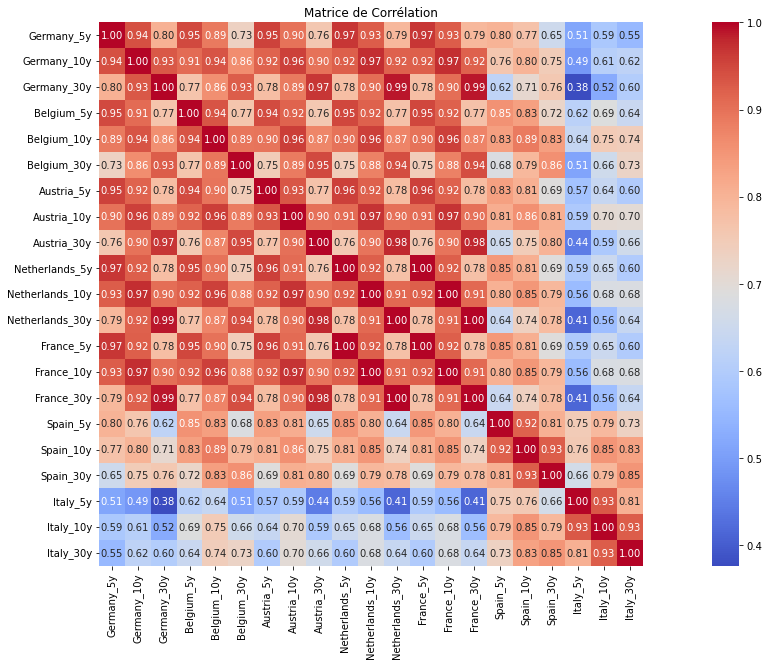

In [162]:
corr = data_manager.data.diff(5).corr()

plt.figure(figsize=(25, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.title('Matrice de Corrélation')
plt.show()

In [166]:
data_manager.data.diff(5).corr().sum().sort_values(ascending=False).head(5)

Belgium_10y        18.383139
Austria_10y        18.381252
Netherlands_10y    18.370138
France_10y         18.370138
Germany_10y        18.012549
dtype: float64

It's not best practice, because it's not the exact correlations we're after, but it's a first approximation of the assets we'll try to predict.

To improve this method, I will run regressions on a reduced dataset (to avoid having poor predictors). I will set the Y value as the difference in yield over the next 5 days, and in the dataset, I will include the difference in yield over the last 5 days for other assets.

I will perform a linear regression for each asset to see which one is best predicted; it will serve as the asset for future tests.

In [175]:
new_data = data_manager.data.diff(5)
new_data = new_data.dropna(axis=0)
df = new_data[new_data.index<"2017-03-01"]

model = LinearRegression()

results = []

for column in df.columns:
    y = df[column].shift(-5)
    X = df.drop(columns=[column]).iloc[:-5]
    y = y.dropna()
    y.to_numpy()
    X.to_numpy()
    if not X.empty and len(X) == len(y):
        model.fit(X, y)
        predictions = model.predict(X)
        mse = mean_squared_error(y, predictions)
        rmse = np.sqrt(mse)
        result = {
            'column': column,
            'score': model.score(X, y),
             'MSE': mse,
            'RMSE': rmse
        }
        results.append(result)

results_df = pd.DataFrame(results)
results_df.sort_values("score", ascending=False)


,column,score,MSE,RMSE
6,Austria_5y,0.306721,19.441704,4.409275
7,Austria_10y,0.262507,50.070844,7.076075
0,Germany_5y,0.254458,21.471110,4.633693
2,Germany_30y,0.251393,83.933046,9.161498
14,France_30y,0.239183,83.486647,9.137103
11,Netherlands_30y,0.239183,83.486647,9.137103
1,Germany_10y,0.228937,47.620530,6.900763
13,France_10y,0.224433,46.321418,6.805984
10,Netherlands_10y,0.224433,46.321418,6.805984
8,Austria_30y,0.222282,86.872038,9.320517


In [180]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

class ModelTrainer:
    def __init__(self, data, start_date, end_date):
        self.data = data
        self.start_date = start_date
        self.end_date = end_date
        self.results_df = None
        self.df = None

    def preprocess_data(self):
        new_data = self.data.diff(5)
        new_data = new_data.dropna(axis=0)
        self.df = new_data[(new_data.index >= self.start_date) & (new_data.index < self.end_date)]

    def train_and_evaluate(self):
        if self.df is None:
            self.preprocess_data()

        model = LinearRegression()
        results = []

        for column in self.df.columns:
            y = self.df[column].shift(-5)
            X = self.df.drop(columns=[column]).iloc[:-5]
            y = y.dropna()
            y.to_numpy()
            X.to_numpy()
            if not X.empty and len(X) == len(y):
                model.fit(X, y)
                predictions = model.predict(X)
                mse = mean_squared_error(y, predictions)
                rmse = np.sqrt(mse)
                result = {
                    'column': column,
                    'score': model.score(X, y),
                    'MSE': mse,
                    'RMSE': rmse
                }
                results.append(result)

        self.results_df = pd.DataFrame(results)
        return self.results_df.sort_values("score", ascending=False)



model_trainer = ModelTrainer(data_manager.data, '2016-01-01', '2017-03-01')
model_trainer.train_and_evaluate()


,column,score,MSE,RMSE
6,Austria_5y,0.306721,19.441704,4.409275
7,Austria_10y,0.262507,50.070844,7.076075
0,Germany_5y,0.254458,21.471110,4.633693
2,Germany_30y,0.251393,83.933046,9.161498
14,France_30y,0.239183,83.486647,9.137103
11,Netherlands_30y,0.239183,83.486647,9.137103
1,Germany_10y,0.228937,47.620530,6.900763
13,France_10y,0.224433,46.321418,6.805984
10,Netherlands_10y,0.224433,46.321418,6.805984
8,Austria_30y,0.222282,86.872038,9.320517


# Pour aller plus loin

### Données économiques que l'on pourrait rajouter pour aller plus loin :

- Inflation
- Chômage
- PIB (Produit Intérieur Brut)
- Indice des prix à la consommation
- Indice des prix à la production (IPP)
- Balance commerciale
- Indices boursiers
- Indicateurs de sentiment de marché
